In [22]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.ops import unary_union
from matplotlib.patches import Patch
import itertools
from scipy.spatial import HalfspaceIntersection
from scipy.optimize import linprog

In [23]:
def augment_with_bounds(A, b, xlim, ylim):
    # Add constraints for bounding box: x >= xlim[0], x <= xlim[1], y >= ylim[0], y <= ylim[1]
    A_box = np.array([
        [-1, 0],  # -x <= -x_min → x >= x_min
        [1, 0],   # x <= x_max
        [0, -1],  # -y <= -y_min → y >= y_min
        [0, 1]    # y <= y_max
    ])
    b_box = np.array([
        -xlim[0],
         xlim[1],
        -ylim[0],
         ylim[1]
    ])
    
    A_aug = np.vstack([A, A_box])
    b_aug = np.hstack([b, b_box])
    return A_aug, b_aug


In [24]:
def get_polygon_from_halfspaces(A, b, epsilon=1e-5):
    b_strict = b - epsilon
    res = linprog(c=np.zeros(A.shape[1]), A_ub=A, b_ub=b_strict)
    if not res.success:
        raise ValueError("Could not find strictly interior feasible point.")

    interior_point = res.x
    halfspaces = np.hstack([A, -b.reshape(-1, 1)])
    hs = HalfspaceIntersection(halfspaces, interior_point)

    # Sort points in counter-clockwise order to avoid invalid polygon
    center = np.mean(hs.intersections, axis=0)
    sorted_points = sorted(hs.intersections, key=lambda p: np.arctan2(p[1] - center[1], p[0] - center[0]))

    poly = Polygon(sorted_points)

    # Fix any topology issues
    if not poly.is_valid:
        poly = poly.buffer(0)

    return poly

In [31]:
def plot_regions_with_overlap(region_constraints_list, xlim=(-10, 10), ylim=(-10, 10)):
    # Create polygons for each region
    region_polygons = []
    for A, b in region_constraints_list:
        A_aug, b_aug = augment_with_bounds(A, b, xlim, ylim)
        poly = get_polygon_from_halfspaces(A_aug, b_aug)
        
        bbox = Polygon([(xlim[0], ylim[0]), (xlim[1], ylim[0]),
                (xlim[1], ylim[1]), (xlim[0], ylim[1])])
        
        # Intersect only after ensuring polygon is valid
        if poly.is_valid:
            poly = poly.intersection(bbox)
        else:
            poly = poly.buffer(0).intersection(bbox)
        
        region_polygons.append(poly)

    # Create union of combinations of regions
    region_union_polys = {}
    for r in range(1, len(region_polygons)+1):
        for combo in itertools.combinations(range(len(region_polygons)), r):
            inter_poly = region_polygons[combo[0]]
            for i in combo[1:]:
                inter_poly = inter_poly.intersection(region_polygons[i])
            if not inter_poly.is_empty:
                region_union_polys[combo] = inter_poly

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(region_union_polys) + 1))

    legend_handles = []
    for i, (combo, poly) in enumerate(region_union_polys.items()):
        ax.fill(*poly.exterior.xy, alpha=0.6, color=colors[i], label=f"Overlap: {combo}")
        legend_handles.append(Patch(color=colors[i], label=f"Overlap: {combo}"))

    # Optional: plot boundaries of each region
    for i, poly in enumerate(region_polygons):
        x, y = poly.exterior.xy
        ax.plot(x, y, linestyle='--', label=f'Region {i}', linewidth=1.5)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal')
    ax.legend(handles=legend_handles)
    ax.set_title("Region Overlap Visualization")
    plt.grid(True)
    plt.show()

In [32]:
# --- Example usage ---

# Define regions as (A, b) for A x <= b
region_constraints_list = [
    (np.array([[5, 8], [1, 0]]), np.array([64, 8])),      # square from (0,0) to (5,5)
    (np.array([[-5, 7], [-1, 0]]), np.array([6, -3])),      # square from (3,3) to (8,8)
    (np.array([[-1, -1], [1, -1]]), np.array([-8, 2]))       # square from (1,1) to (7,7)
]

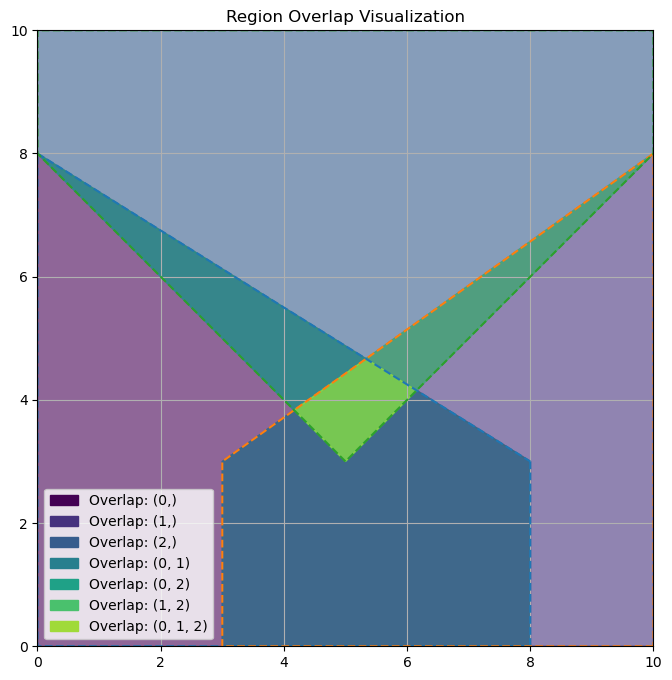

In [33]:
plot_regions_with_overlap(region_constraints_list, xlim=(0,10), ylim=(0,10))